## Description:

This file contains:
* clustering to find out number/nature of natural grouping within the data

In [1]:
'''Helper''' 
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
import numpy as np
import time
import joblib

'''Visualization'''
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.1f' % x)

'''GCS'''
from gcs_utils import *

In [2]:
'''Modeling'''
from sklearn.decomposition import PCA
from sklearn.preprocessing import (RobustScaler, 
                                   StandardScaler)
from sklearn.cluster import (KMeans, 
                             MiniBatchKMeans)

from sklearn.metrics import (silhouette_samples, 
                             silhouette_score, 
                             davies_bouldin_score)

from sklearn.cluster import DBSCAN

In [ ]:
BUCKET_NAME = 'bi-subscription-modeling'
BUCKET_FOLDER = 'train-val-data/pv1-filter-train-val'
file_name = 'pv1_training_data_01062022.csv'

download_file(BUCKET_NAME, 
              BUCKET_FOLDER, 
              file_name) 

* **Read data**

In [3]:
# read training data

raw_df = pd.read_csv('pv1_training_data_01062022.csv', dtype={'ga_fullvisitorid': object})

# fill any Nulls with 0

raw_df.fillna(0, inplace=True)

# drop unnecessary cols
cols_to_drop = [x for x in raw_df.columns if 'other' in x]

raw_df = raw_df.drop(cols_to_drop, 
                     axis=1)

print(raw_df.shape)

# print(raw_df.isna().sum().unique())
# print(raw_df.dtypes.value_counts(), "\n")

print(raw_df.subscription_status.value_counts())

(506819, 562)
non_subscriber    409924
subscriber         96895
Name: subscription_status, dtype: int64


* All features are behaving as numerical features at this point

In [4]:
# read selected features during v1 modeling
# feat_selected = joblib.load("subs_feat_selected.joblib")

raw_df.head()

,ga_fullvisitorid,session_pvs_mean,session_pvs_median,session_top_mean,session_top_median,bounce_rate,content_views_rate,rf_content_aggregators,rf_direct,rf_fbia,...,hour_15_top,hour_16_top,hour_17_top,hour_18_top,hour_19_top,hour_20_top,hour_21_top,hour_22_top,hour_23_top,subscription_status
0,10000008659404174067,2.0,2.0,90.0,90.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,non_subscriber
1,1000005318256837109,1.0,1.0,889.5,889.5,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non_subscriber
2,10000099310184199031,1.0,1.0,263.0,319.0,1.0,1.0,0.0,0.0,0.0,...,0.0,319.0,0.0,527.0,366.0,0.0,0.0,0.0,0.0,non_subscriber
3,10000101531876397645,1.0,1.0,820.0,820.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non_subscriber
4,10000193311213787727,1.0,1.0,124.0,124.0,1.0,1.0,2.0,0.0,0.0,...,0.0,0.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,non_subscriber


* **Pre-process data**

In [6]:
# keep only subs for clustering

df = raw_df[raw_df.subscription_status== 'subscriber']
data = df[df.columns[~df.columns.isin(['subscription_status', 'ga_fullvisitorid'])]]
data.shape

(96895, 560)

* RobustScaler because:
    * Data has outliers which we dont want to get rid of
    * kMeans is sensitive to scale

In [7]:
scaled_data = RobustScaler().fit_transform(data)

In [8]:
# from sklearn.preprocessing import QuantileTransformer
# scaled_data =  QuantileTransformer(output_distribution="uniform").fit_transform(data) # got worse results

# NOTE - The highest silhouette score is not always the idicator of the best k-mean cluster composition found. Relative cluster sizes as well as the fact of having all of the clusters popping above the silhouette lines play the important role, too. 
# NOTE - In genomics PCA have less than 5% explanatory value in the first PC-axis because of thousands of variables

# Ref: 
# [1](https://www.researchgate.net/post/PCA_What_to_do_when_each_Principal_Component_explains_10_of_variance) 
# [2](https://stats.stackexchange.com/questions/519504/significance-of-low-variance-components-of-pca-for-lower-dimensional-clustering)

* PCA
    * reduce dimensionality - goes nicely with kMeans because it preserves distances better compared to say t-SNE
    * will convert possibly correlated variables into linearly uncorrelated variables called principal components without taking any target variable into consideration
        * thats why not dropping correlated variables beforehand

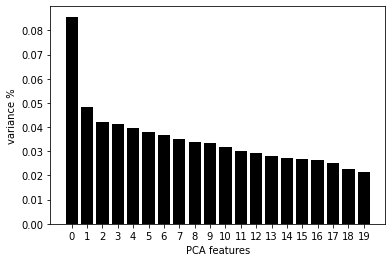

In [8]:
pca = PCA(n_components=20)
pc_out = pca.fit_transform(scaled_data)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(pc_out) 

* Select first two PCs
* These 2 PCs explain 13% variance in data. For clustering we should still be able to find groups
    * Usually the variance explained by each axis decreases with the number of variables. 

In [9]:
final_pca = PCA(n_components=2)
reduced_data = final_pca.fit_transform(scaled_data)

print('Explained variation per PC: {}'.format(final_pca.explained_variance_ratio_))
print('Cumulative variance explained by 2 PCs: {:.2%}'.format(np.sum(final_pca.explained_variance_ratio_)))

Explained variation per PC: [0.08565414 0.04844799]
Cumulative variance explained by 2 PCs: 13.41%


In [10]:
# first PC's top features include - what they read, when 

chk = abs( pca.components_ )
print(chk.shape)

pc1_all = list(chk[0])
cols_all = data.columns.to_list()

sorted(zip(pc1_all,cols_all), reverse=True)[:25]

(20, 560)


[(0.34137317906738057, 't1_careers_top'),
 (0.2975392203371167, 't1_travel_top'),
 (0.2943445319959302, 't1_style_and_fashion_top'),
 (0.28682281678835864, 't1_shopping_top'),
 (0.22960041641995083, 't1_food_and_drink_top'),
 (0.22371133854690983, 't1_automotive_top'),
 (0.21159681679174264, 't1_sports_top'),
 (0.2092165211667612, 't1_events_and_attractions_top'),
 (0.2079425551937959, 'hour_22_top'),
 (0.2024536464353068, 't1_education_top'),
 (0.19726311988638853, 'day_of_mon_31_top'),
 (0.18446009923320847, 't1_science_top'),
 (0.17580539262156877, 't1_real_estate_top'),
 (0.15936213693598922, 't1_healthy_living_top'),
 (0.15523118651038634, 't1_television_top'),
 (0.1400893640257977, 'hour_7_top'),
 (0.13598173282903198, 't1_home_and_garden_top'),
 (0.1258398674293392, 't1_family_and_relationships_top'),
 (0.12407591358969182, 'hour_0_top'),
 (0.12401749428862148, 'hour_23_top'),
 (0.1105956482673421, 't1_music_and_audio_top'),
 (0.10556601305286079, 't1_pop_culture_top'),
 (0.1008

* visualize dataset to see if separate/natural groups available
    * hard clustering problem

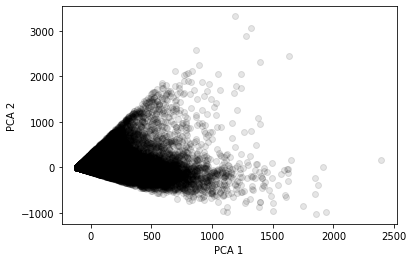

In [11]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [ ]:
X  = reduced_data.copy()
X.shape

* Algorithm: K-Means
* Cluster selection: Silhouette analysis and score
    * Silhouette score is a measure of cluster seperation and similarity

    * Silhouette analysis
        * Displays a measure of how close each point in one cluster is to points in the neighboring clusters by plotting per data point silhouette score. Provides a way to assess number of clusters to choose visually
        * Silhouette coefficients:
            * near +1 = sample is far away from the neighboring clusters
            * value of 0 = sample is on or very close to the decision boundary between two neighboring clusters 
            * negative values = indicate that those samples might have been assigned to the wrong cluster.
        * The vertical dashed line is the average silhouette score across all clusters. 
       
        * The cluster group height indicates the size of the cluster. 

* **Obs:**
    *  n_clusters=3 highest score. 
    * Uneven cluster sizes
        * Maybe nature of our users? Most may be casual subs, small % may be niche subs? 
    * 2 out of 3 clusters with below average silhouette scores but data points going towards -1 are less 

[Sklearn Ref](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

For n_clusters = 2 The average silhouette_score is : 0.7034160419164709
For n_clusters = 3 The average silhouette_score is : 0.7161500378229945
For n_clusters = 4 The average silhouette_score is : 0.6289451135704481
For n_clusters = 5 The average silhouette_score is : 0.5533570326116024
For n_clusters = 6 The average silhouette_score is : 0.5159611133143569


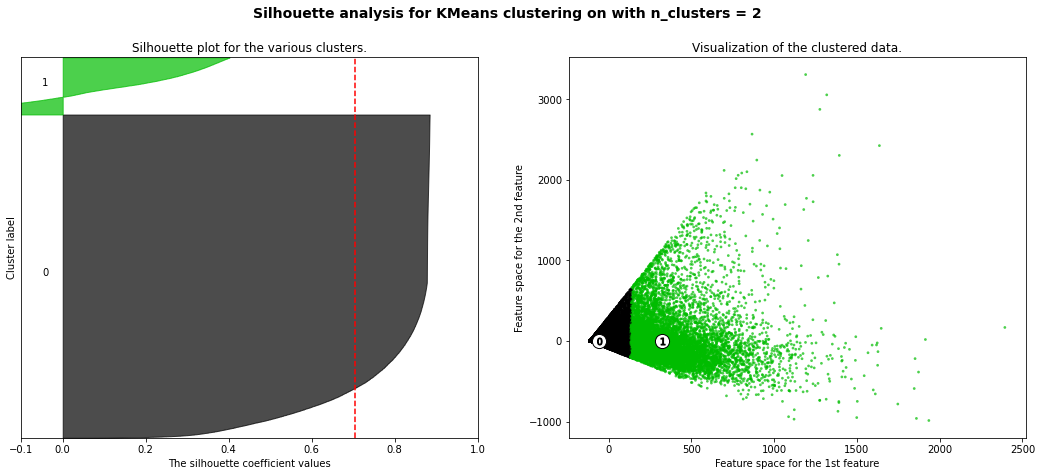

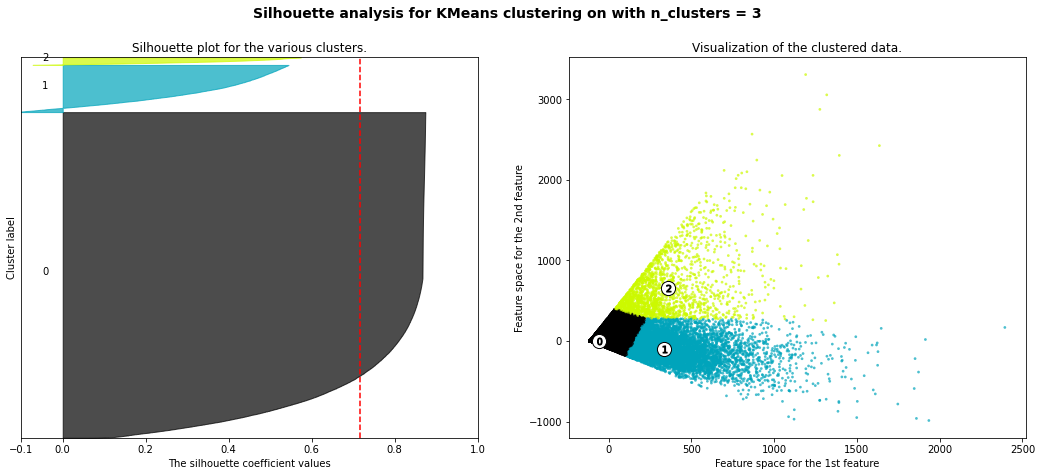

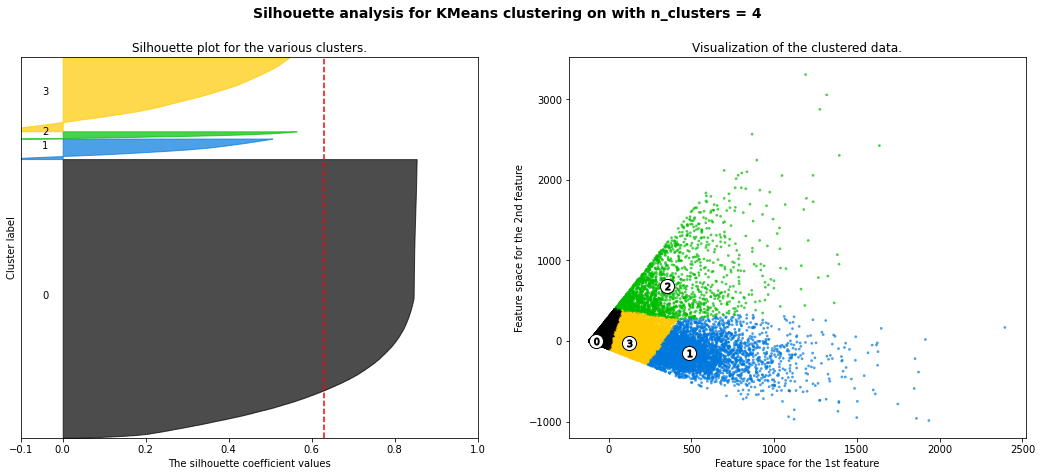

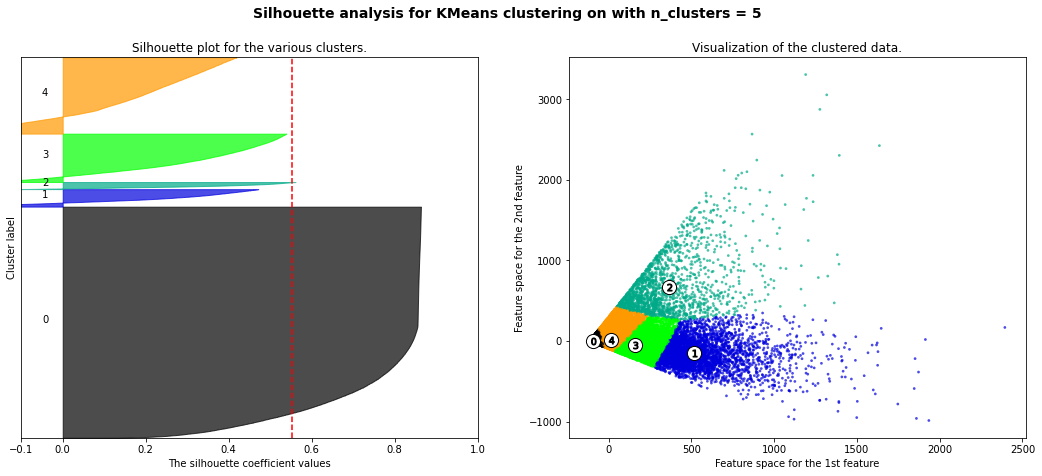

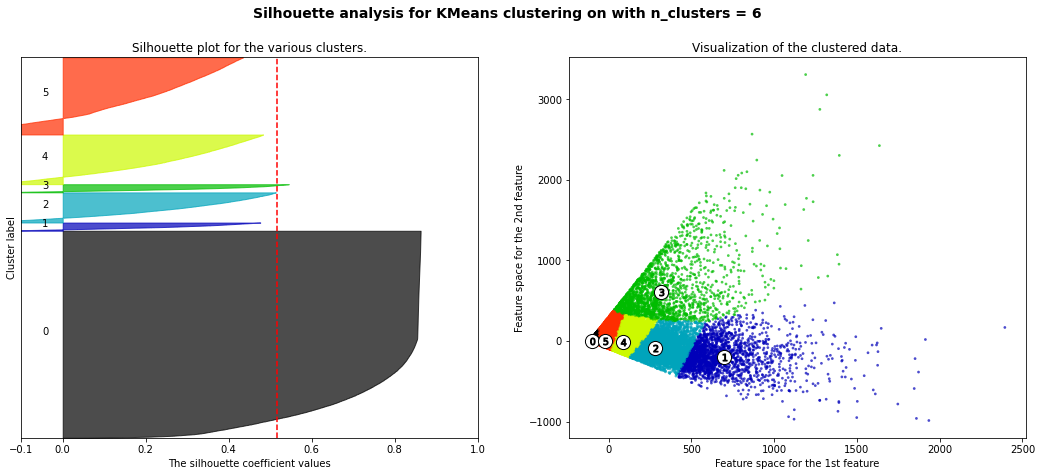

Took 970 seconds to run


In [13]:
start = time.time()

n_clusters_lst = {}

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot. The silhouette coefficient can range from -1, 1 
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.

    clusterer = MiniBatchKMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples. This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    n_clusters_lst[n_clusters] = silhouette_avg

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

print('Took {} seconds to run'.format(round(time.time() - start))) 

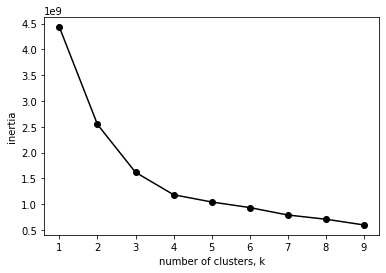

In [14]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = MiniBatchKMeans(n_clusters=k, random_state=10)
    
    # Fit model to samples
    model.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show() 

* **KMeans**

In [15]:
clusterer = MiniBatchKMeans(n_clusters=3, random_state=10)

cluster_labels = clusterer.fit_predict(X)

print("Davies-Bouldin score: ", 
      round(davies_bouldin_score(X, cluster_labels), 2))

print("Silhouette score: ", 
      round(silhouette_score(X, cluster_labels), 2))

df["cluster_id"] = cluster_labels

print("\n Cluster size distribution:\n", 
      df["cluster_id"].value_counts())

print("\n Cluster size % distri:\n", 
      df["cluster_id"].value_counts(normalize=True)*100)

Davies-Bouldin score:  0.68
Silhouette score:  0.72

 Cluster size distribution:
 0    82953
1    12016
2     1926
Name: cluster_id, dtype: int64

 Cluster size % distri:
 0   85.6
1   12.4
2    2.0
Name: cluster_id, dtype: float64


* **Challenger - Hierarchical clustering**

In [16]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=3) 

cluster_labels = model.fit_predict(X) 

print("Davies-Bouldin score: ", davies_bouldin_score(X, cluster_labels))

print("Silhouette score: ", silhouette_score(X, cluster_labels))

print("Cluster size distribution:\n", pd.DataFrame(cluster_labels).value_counts())

print("Cluster size distribution:\n", pd.DataFrame(cluster_labels).value_counts(normalize=True))

# assign labels to df
plot_df = pd.DataFrame(X)
plot_df["label"] = cluster_labels #5mins

Davies-Bouldin score:  0.8557555602809771
Silhouette score:  0.7157300687724992
Cluster size distribution:
 1    82287
2    10140
0     4468
dtype: int64
Cluster size distribution:
 1   0.8
2   0.1
0   0.0
dtype: float64


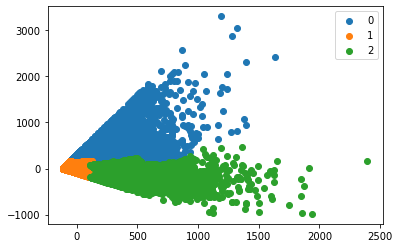

1    82287
2    10140
0     4468
Name: label, dtype: int64

In [17]:
# agglo
u_labels = np.unique(cluster_labels)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(plot_df.loc[plot_df.label == i , 0] , plot_df.loc[plot_df.label == i , 1] , label = i)
plt.legend()
plt.show()

plot_df.label.value_counts()

* **Challenger - Density based clustering**

Davies-Bouldin score:  1.1850914168192057
Silhouette score:  -0.5311334337069511
Cluster size distribution:
 -1      49485
 0      43441
 5        132
 9        108
 17        97
        ...  
 85         7
 180        7
 46         6
 188        5
 150        2
Length: 192, dtype: int64


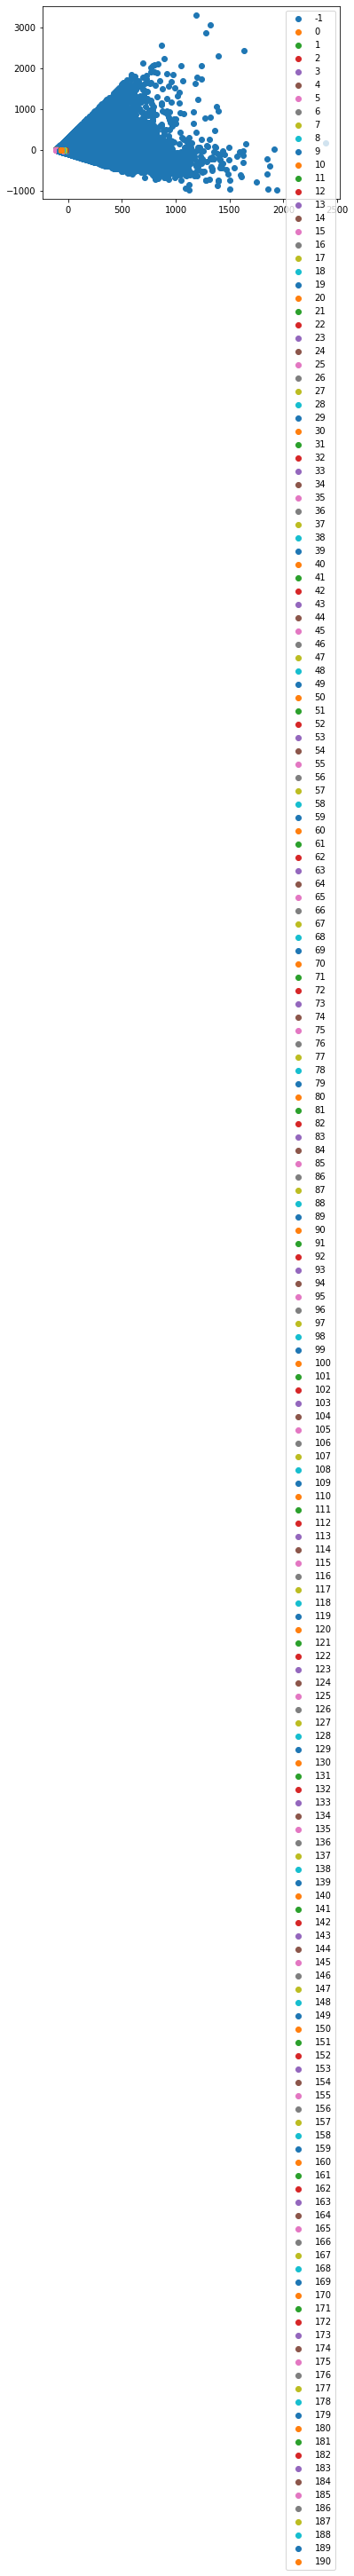

-1      49485
 0      43441
 5        132
 9        108
 17        97
        ...  
 180        7
 164        7
 46         6
 188        5
 150        2
Name: label, Length: 192, dtype: int64

In [18]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.5, min_samples=10) # worse resuls

cluster_labels = model.fit_predict(X) 

print("Davies-Bouldin score: ", davies_bouldin_score(X, cluster_labels))

print("Silhouette score: ", silhouette_score(X, cluster_labels))

print("Cluster size distribution:\n", pd.DataFrame(cluster_labels).value_counts())

# assign labels to df
plot_df = pd.DataFrame(X)
plot_df["label"] = cluster_labels

# agglo
u_labels = np.unique(cluster_labels)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(plot_df.loc[plot_df.label == i , 0] , plot_df.loc[plot_df.label == i , 1] , label = i)
plt.legend()
plt.show()

plot_df.label.value_counts()

* Save kMeans as cluster results

In [19]:
df.to_csv("clustering_result.csv", index=False)